In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

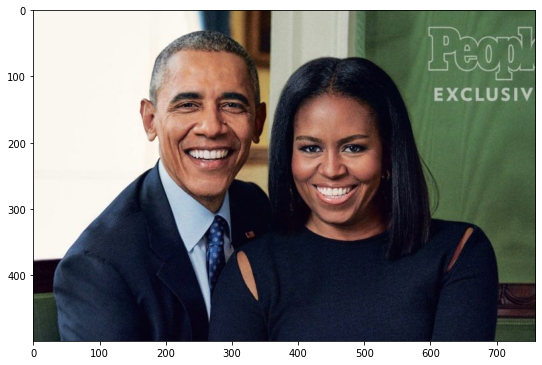

In [2]:
def preprocess_roi(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    normalized = gray/255.
    resized = cv2.resize(normalized, (224,224))
    return resized

image = cv2.imread('images/obamas.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

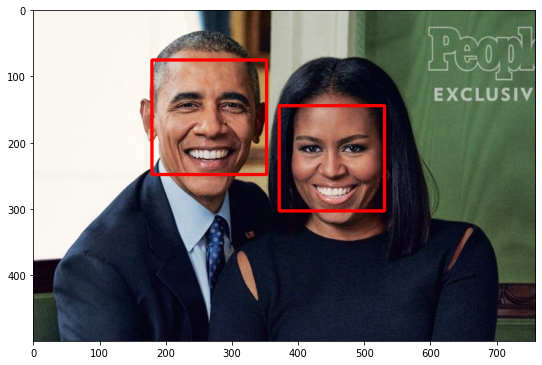

In [3]:
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(image, 1.2, 2)

image_with_detections = image.copy()

for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [4]:
from models import Net

net = Net()
net.load_state_dict(torch.load('v2_model.pt'))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (bn6): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [15]:
image_copy = np.copy(image)

# haar cascade find very tight face region, it's better to add some padding
padding = 30

images = []
keypoints = []

for (x,y,w,h) in faces:
    roi = image_copy[y-padding:y+h+padding, x-padding:x+w+padding]
    roi = preprocess_roi(roi)    
    
    # add 1 dim as batch dim and 1 dim as color channel
    batch = torch.tensor(roi, dtype=torch.float32).reshape([1,1,roi.shape[0], roi.shape[1]])
    
    preds = net(batch)
    preds = preds.data.reshape(-1, 2).numpy()*50.+100

    images.append(roi)
    keypoints.append(preds)


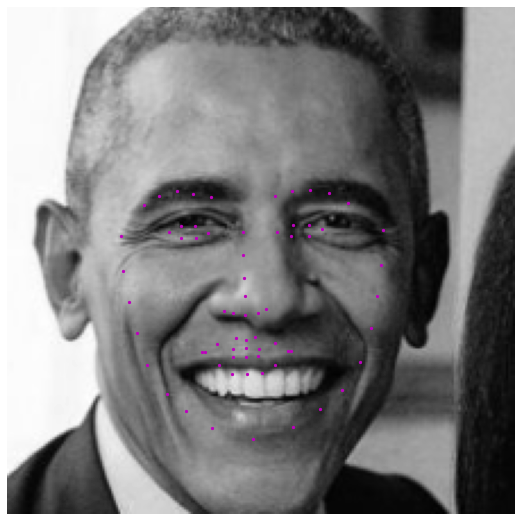

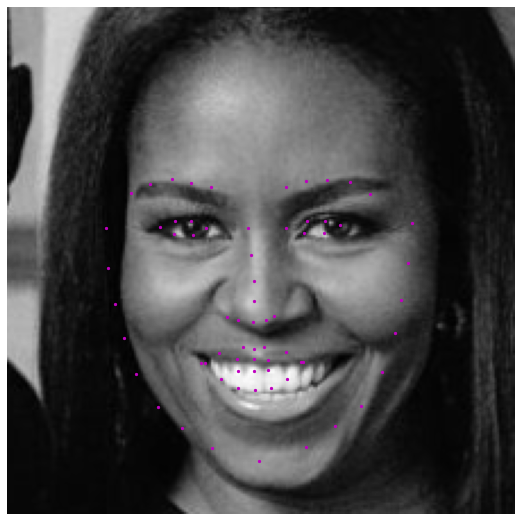

In [16]:
faces_count = len(images)

for i in range(faces_count):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1, faces_count, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.scatter(keypoints[i][:, 0], keypoints[i][:, 1], s=20, marker='.', c='m')
    plt.axis("off")
plt.show()